# Project 5 - Vehicle Detection
## written by Moshe Roth

# imports

In [1]:
import numpy as np
import os
import cv2
import glob
import collections
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
from lesson_functions import *
from scipy.ndimage.measurements import label

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

# Helper functions

In [2]:
def plot_2_images(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def show_bulk_images(images, cols = 2, rows = 3, figsize=(15,13)):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            image = images[index]
            ax.imshow(image)

# Get images

In [3]:

def get_images(dir, pattern):
    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern`.
    """
    images = []
    for dirpath, dirnames, filenames in os.walk(dir):
        for dirname in dirnames:
            images.append(glob.glob(dir + '/' + dirname + '/' + pattern))
    flatten = [item for sublist in images for item in sublist]
    return list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), flatten))

vehicles = get_images('/data/vehicles', '*.png')
non_vehicles = get_images('/data/non-vehicles', '*.png')

In [4]:
print (len(vehicles), len(non_vehicles))

(8792, 8968)


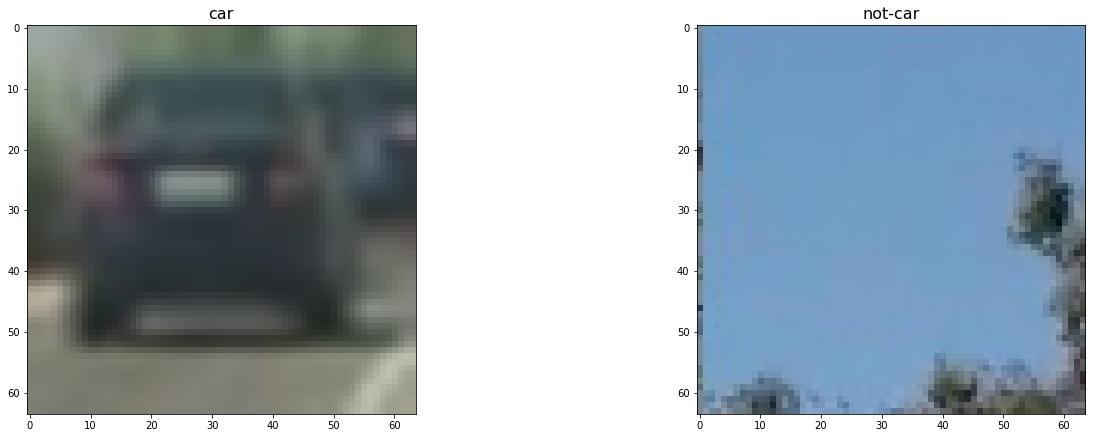

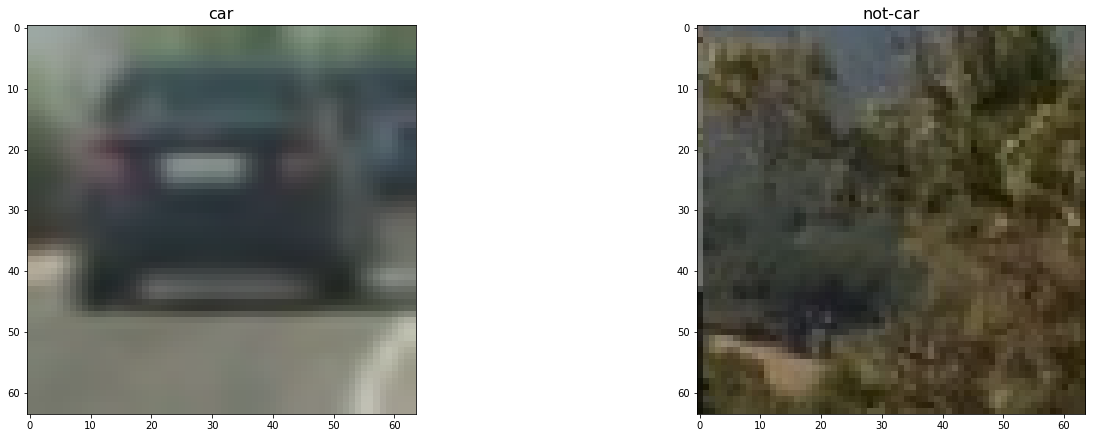

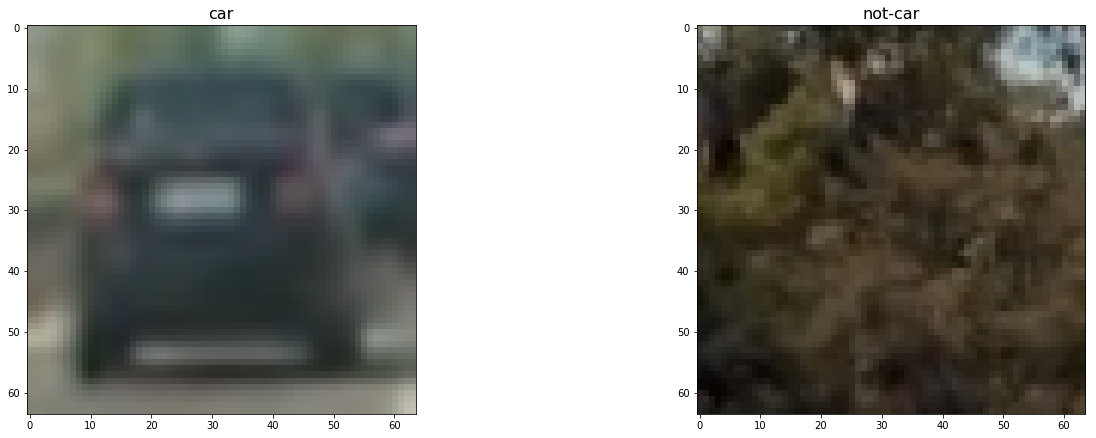

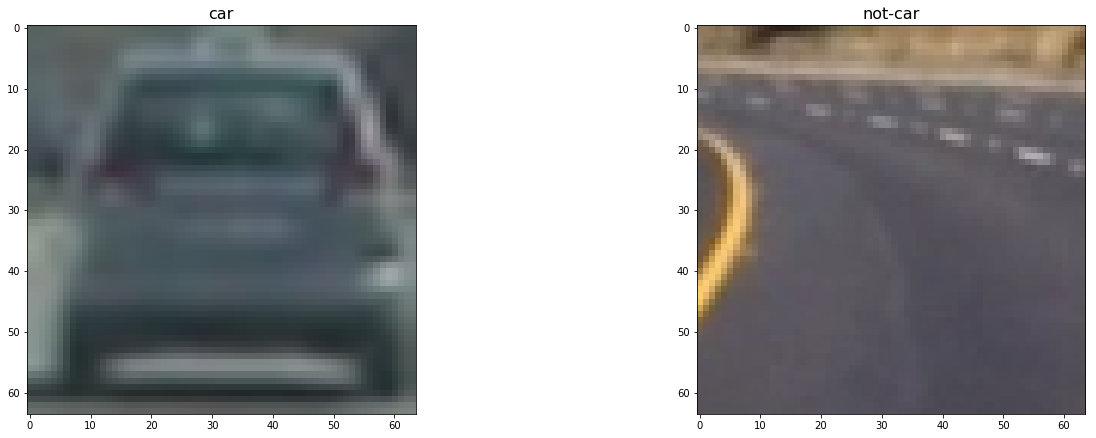

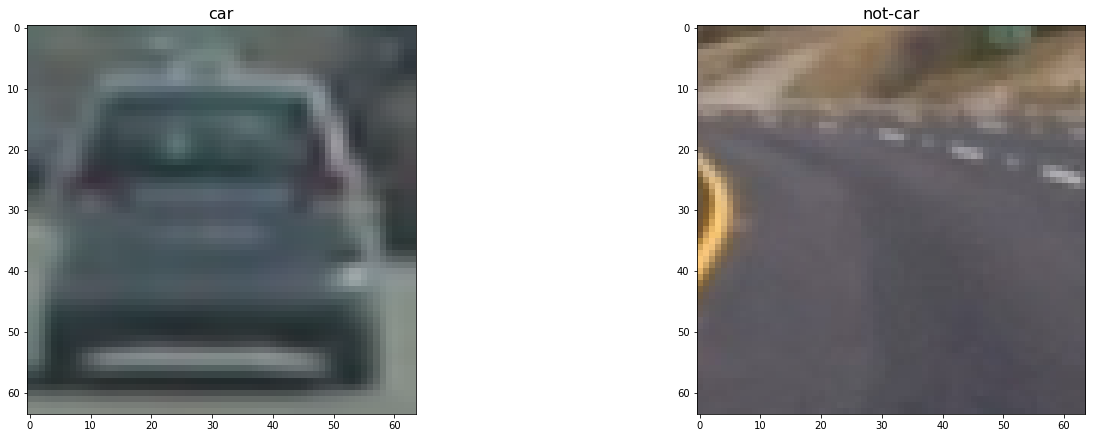

In [5]:
for i in range(5):
    plot_2_images(vehicles[i],non_vehicles[i],'car','not-car')


# Hog features

In [6]:
def draw_hog_features(img, title):
    img_cspaced = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    _, hog_y = get_hog_features(img_cspaced[:,:,0], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cr = get_hog_features(img_cspaced[:,:,1], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)
    _, hog_Cb = get_hog_features(img_cspaced[:,:,2], 
                                    params.orient, params.pix_per_cell, params.cell_per_block, 
                                    vis=True, feature_vec=True)

    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y')
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr')
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb')

vehicle = vehicles[0]
non_vehicle = non_vehicles[0]

draw_hog_features(vehicle, 'Vehicle')
draw_hog_features(non_vehicle, 'Non-vehicle')

NameError: global name 'params' is not defined

# Classifier

In [ ]:

class FeaturesParameters():
    def __init__(self):
        # HOG parameters
        self.cspace = 'YCrCb'
        self.orient = 8
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.hog_channel = 'ALL'
        # Bin spatial parameters
        self.size = (16, 16)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 256)

def fitModel( positive, negative, svc, scaler, params ):
    """
    Trains the classifier `svc`. The feature extraction is done using the parameters stored in `params`.
    The feature scalling is done by the scaler `scaler`.
    Returns: (`svc`, fittingTime, accuracy)
    """
    positive_features = list(map(lambda img: extract_features(img, params), positive))
    negatice_features = list(map(lambda img: extract_features(img, params), negative))
    
    # Stacking and scaling
    X = np.vstack((positive_features, negatice_features)).astype(np.float64)    
    X_scaler = scaler.fit(X)
    scaled_X = X_scaler.transform(X)
    
    # Defining objective
    y = np.hstack((np.ones(len(positive_features)), np.zeros(len(negatice_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    
    # Fitting
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    fittingTime = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test),4)
    return (svc, X_scaler, fittingTime, accuracy)

In [ ]:
        
from sklearn.svm import LinearSVC

params = FeaturesParameters()
svc, scaler, fittingTime, accuracy = fitModel(vehicles, non_vehicles, LinearSVC(), StandardScaler(), params)
print('Fitting time: {} s, Accuracy: {}'.format(fittingTime, accuracy))

# Experiment sliding windows

In [ ]:

def findCarWindows(img, clf, scaler, params, y_start_stop=[360, 700], xy_window=(64, 64), xy_overlap=(0.85, 0.85) ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `xy_window` : Contains the windows size.
    `xy_overlap` : Contains the windows overlap percent.
    Returns a new image with the cars boxes.
    """
    car_windows = []
    windows = slide_window(img, y_start_stop=y_start_stop, xy_window=xy_window, xy_overlap=xy_overlap)
    for window in windows:
        img_window = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        features = extract_features(img_window, params)
        scaled_features = scaler.transform(features.reshape(1, -1))
        pred = clf.predict(scaled_features)
        if pred == 1:
            car_windows.append(window)
    return car_windows

def drawCars(img, windows):
    """
    Draw the `windows` on the image `img`.
    """
    output = np.copy(img)
    return draw_boxes(output, windows)


all_test_images = list(map(lambda img: cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), glob.glob('./test_images/*.jpg')))
images = list(map(lambda img: drawCars(img, findCarWindows(img, svc, scaler, params)), all_test_images))
            
show_bulk_images(images)


In [ ]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def drawCarsWithLabels(img, boxes, threshHold = 4):
    """
    Draw the car boxes `boxes` on the image `img` using a heatmap with threshold `threshHold`.
    """
    heatmap = add_heat(np.zeros(img.shape), boxes)
    heatmap = apply_threshold(heatmap, threshHold)
    labels = label(heatmap)
    
    return draw_labeled_bboxes(np.copy(img), labels)
    
images = list(map(lambda img: drawCarsWithLabels(img, findCarWindows(img, svc, scaler, params)), all_test_images))

show_bulk_images(images)


# Hog subsampling

In [ ]:
def findBoxes(img, clf, scaler, params, y_start_stop=[350, 656], window=64, cells_per_step=1, scale=1.5 ):
    """
    Returns the windows where the cars are found on the image `img`.
    The feature extraction used parameters `params`.
    `y_start_stop` : Contains the Y axis range to find the cars.
    `window` : Number of windows.
    `cells_per_step` : Number of cells per step.
    Returns a new image with the cars boxes.
    """
    # Parameters extraction
    # HOG parameters
    cspace = params.cspace
    orient = params.orient
    pix_per_cell = params.pix_per_cell
    cell_per_block = params.cell_per_block
    hog_channel = params.hog_channel
    # Spatial parameters
    size = params.size
    # Histogram parameters
    hist_bins = params.hist_bins
    hist_range = params.hist_range
    
    
    # Image color space changes
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    ystart, ystop = y_start_stop
    ctrans_tosearch = feature_image[ystart:ystop,:,:]
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    car_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)
            
            #print hog_features.shape
            #print spatial_features.shape
            #print hist_features.shape
            
            # Scale features and make a prediction
            features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #print features.shape
            test_features = scaler.transform(features)    
            test_prediction = clf.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                car_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return car_windows

# Heatmaps operations

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Run the pipeline on a test image

In [ ]:
class HeatHistory():
    def __init__(self):
        self.history = []

def pipeline(image):
    boxes = findBoxes(image, svc, scaler, params)
    img_shape = image.shape
    heatmap = add_heat(np.zeros(img_shape), boxes)
    if len(history.history) >= history_backlog:
        history.history = history.history[1:]

    history.history.append(heatmap)
    heat_history = reduce(lambda h, acc: h + acc, history.history)/history_backlog
    heatmap = apply_threshold(heat_history, 1)
    labels = label(heatmap)

    return draw_labeled_bboxes(np.copy(image), labels)

In [ ]:
history = HeatHistory()

def run_pipeline (imgame):
    image = mpimg.imread(imgame)
    history_backlog = 1
    image = pipeline(image)
    plt.imshow(image)


In [ ]:
run_pipeline('test_images/test1.jpg')

In [ ]:
run_pipeline('test_images/test2.jpg')

In [ ]:
run_pipeline('test_images/test3.jpg')

In [ ]:
run_pipeline('test_images/test4.jpg')

# Apply Advanced Lane Detection on our video

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output_video = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline)
%time video_clip.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))